In [ ]:
#Data Cleaning
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_squared_error
#Data is saved on diffrent CSVs for each city
#To make things easier, we can combine the data into one dataframe
dfs = []
for file in os.listdir("data"):
    df = pd.read_csv(os.path.join("data", file))
    df["City"] = file.replace(".csv", "")
    dfs.append(df)
df = pd.concat(dfs)

#As documented on kaggle, 9 implies that this information was not found for a home.
#Therefore we replaced all 9s with np.nan as is standard for empty values

temp = df["No. of Bedrooms"].copy()
df = df.applymap(lambda x: (np.nan if x == 9  else  x))
df["No. of Bedrooms"] = temp
df

In [ ]:
cleaned_df = df[~df.isnull().any(axis=1)]
cleaned_df

Below, I one-hot encode the location and city columns

In [ ]:
cleaned_df = pd.get_dummies(cleaned_df,columns=["City"]) #"Location"
cleaned_df = cleaned_df.drop(["Location"], axis=1)
##

In [ ]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df.drop("Price", axis=1), 
    cleaned_df["Price"], 
    test_size=0.2, 
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=42
)


In [ ]:
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
mse = mean_squared_error(y_test, reg.predict(X_test))
reg.score(X_test,y_test)

## Neural Network

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

In [ ]:
cleaned_df.shape[0]

In [ ]:
mean = cleaned_df["Price"].mean()
std = cleaned_df["Price"].std(ddof=0)
cleaned_df = cleaned_df[np.abs((cleaned_df["Price"] - mean)/std) < 5]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class dataframeDataset(Dataset):
    def __init__(self, X, y, zscored=True, train_mean=0, train_std=0):
        self.X = X
        self.Y = y
        if (zscored):
            self.Y_zscored = (self.Y - self.Y.mean())/self.Y.std(ddof=0)
            print(self.Y_zscored.argmax())
        else:
            if (train_std == 0):
                raise "train_std not set"
            self.Y_zscored = (self.Y - train_mean)/train_std 

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        #print("idx", torch.Tensor(self.X.iloc[idx]).dtype, float(self.Y.iloc[idx]))
        #if (self.zscored):
        return (
            torch.Tensor(self.X.iloc[idx]), 
            torch.Tensor([float(self.Y_zscored.iloc[idx])])
        )
        # else:
        #     return (
        #         torch.Tensor(self.X.iloc[idx]), 
        #         torch.Tensor([float(self.Y.iloc[idx])])
        #     )
    
    def get_mean_std(self):
        return self.Y.mean(), self.Y.std(ddof=0)

dataframeDataset(X_train, y_train) 

In [ ]:
from torch.utils.data import DataLoader
train_dataset = dataframeDataset(X_train, y_train) 
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

mean, std = train_dataset.get_mean_std()

print("===================")
test_dataset = dataframeDataset(X_test, y_test) 
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

valid_dataset = dataframeDataset(X_valid, y_valid) 
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [ ]:
lr=.0001
epochs = 40
verbose = False

class NNRegressor_V1(nn.Module):
    def __init__(self, does_drop=True, skip_count=0, fc_count=4, reduct=True, loss_name="MSE"):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(44, 32)
        self.hidden = nn.Linear(32, 32)
        self.hidden1 = nn.Linear(32, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.hidden3 = nn.Linear(8, 4)
        self.output_red = nn.Linear(4, 1)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmod = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.2)

        self.does_drop  = does_drop
        self.skip_count = skip_count 
        self.fc_count = fc_count
        self.reduct = reduct
        self.loss_name = loss_name

    def generate_model_name(self):
        return(
            f"skip-{self.skip_count}_" + 
            f"non-skip-{self.fc_count}_" +
            f"dropout:{self.does_drop}_" +
            f"reduction:{self.reduct}_{self.loss_name}"
        )

    def skip_connection(self, x, ):
        og_x = x
        x = self.hidden(x)
        x = self.relu(x)
        if (self.does_drop):
            x = self.drop(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = x + og_x
        return x


    ### Contains all model architerctures we want to experiment with
    def algorithms(self, x, skip_count=0, fc_count=0, reduct=False):
        x = self.input(x)

        for _ in range(skip_count):
          x = self.skip_connection(x)


        if (reduct):
            input_size = 32
            for _ in range(fc_count):
                x = (nn.Linear(input_size, input_size//2))(x)
                input_size = input_size //2
                x = self.relu(x)
            return nn.Linear(input_size, 1)(x)

        else:
            for _ in range(fc_count):
                x = self.hidden(x)
                x = self.relu(x)
            return self.output(x)
          


    def forward(self, x):
        return self.algorithms(
            x,
            self.skip_count,
            self.fc_count,
            self.reduct
        )
    
model = NNRegressor_V1()
model_name = model.generate_model_name()

In [ ]:
from sklearn.metrics import r2_score

def train_loop(dataloader, valid_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    losses = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            losses.append(loss)
            if(verbose):
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, r_squared, MSE_result = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    count = 0
    with torch.no_grad():
        for X, y in dataloader:
            
            count += 1
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            r_squared += float(r2_score(pred, y))
            MSE_result += mean_squared_error(pred, y)
            

    #print(count, num_batches, size)
    test_loss /= num_batches
    r_squared /= num_batches
    MSE_result /= num_batches
    if(verbose):
        print(f"Test Error: Avg loss: {test_loss:>8f}, R: {r_squared:>8f}, MSE {MSE_result:>8f}\n") # Avg rsqaure {correct:>8f} 
    return test_loss, r_squared, MSE_result

In [ ]:
#OLD CODE
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# losses = []
# r_squared_list = []
# MSE_result_list = []
# for t in range(epochs):
#     if(verbose):
#         print(f"Epoch {t+1}\n-------------------------------")
#     loss = train_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer)
#     test_loss, r_squared, MSE_result = test_loop(valid_dataloader, model, loss_fn)
#     r_squared_list.append(r_squared)
#     MSE_result_list.append(MSE_result)
# print("Done!") 


In [ ]:
plt.plot(losses)

In [ ]:
plt.plot(r_squared_list)

In [ ]:
plt.plot(MSE_result_list)

In [ ]:
#input()

test = model_name.replace(":", "")
torch.save(model.state_dict(), f"./models/{test}.pt")

def plot_loss(df, range=(0,2)):
    ax = df.T.plot(kind="line")
    ax.set_ylim(range[0],range[1])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def save_result_y_anaylze(results, name="mse", range=(0,2)):
    past_record = pd.read_csv(f"{name}.csv",index_col=0)
    record = pd.DataFrame(results).T
    record = record.rename({0:model_name})
    record.to_csv("temp.csv")
    record = pd.read_csv("temp.csv")
    full_record = pd.concat([past_record, record], axis=0)
    #display(full_record)
    plot_loss(full_record, range=range)
    full_record.to_csv(f"{name}.csv")

save_result_y_anaylze(MSE_result_list, name="mse")
#save_result_y_anaylze(r_squared_list, name="rsquared", range=(-5, 1.1))


In [ ]:
past_record = pd.read_csv("correctness_scores.csv",index_col=0)
full_record = pd.concat([past_record, pd.read_csv("temp.csv",index_col=0)], axis=0)

In [ ]:
def plot_loss(df):
    ax = df.T.plot(kind="line")
    ax.set_ylim(0,2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_loss(full_record.iloc[16:])

In [ ]:
# ax = full_record.T.plot(kind="line")
# ax.set_ylim(0,2)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def plot_loss(df):
    ax = df.T.plot(kind="line")
    ax.set_ylim(0,2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plot_loss(full_record.iloc[[6, 13, 14, 15]])

In [ ]:
plot_loss(full_record.iloc[16:])

In [ ]:
full_record.to_csv("correctness_scores.csv")

In [51]:
!pip install torchmetrics

                                              0.0/519.2 kB ? eta -:--:--
                                              10.2/519.2 kB ? eta -:--:--
     --                                    30.7/519.2 kB 640.0 kB/s eta 0:00:01
     ------                                92.2/519.2 kB 744.7 kB/s eta 0:00:01
     ----------------                       225.3/519.2 kB 1.3 MB/s eta 0:00:01
     --------------------                   276.5/519.2 kB 1.2 MB/s eta 0:00:01
     -------------------------------------  512.0/519.2 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 519.2/519.2 kB 1.9 MB/s eta 0:00:00


In [53]:
def run_full_experiment(experiments, loss_fn = nn.MSELoss(), loss_name="MSE", verbose=False):
    for experiment in experiments:
        lr=.0001
        epochs = 40
        model = NNRegressor_V1(
            does_drop=experiment["does_drop"], 
            skip_count=experiment["skip_count"], 
            fc_count=experiment["fc_count"],
            reduct=experiment["reduct"], 
            loss_name=loss_name
        )

        model_name = model.generate_model_name()
        print(model_name)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        losses = []
        r_squared_list = []
        MSE_result_list = []
        for t in range(epochs):
            if(verbose):
                print(f"Epoch {t+1}\n-------------------------------")
            loss = train_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer)
            test_loss, r_squared, MSE_result = test_loop(valid_dataloader, model, loss_fn)
            r_squared_list.append(r_squared)
            MSE_result_list.append(MSE_result)
        print("Done!") 

        #input()

        model_name_file = model_name.replace(":", "-")
        torch.save(model.state_dict(), f"./models/{model_name_file}.pt")

        def plot_loss(df, range=(0,2)):
            ax = df.T.plot(kind="line")
            ax.set_ylim(range[0],range[1])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        def save_result_y_anaylze(results, model_name=model_name, name="mse", range=(0,2)):
            past_record = pd.read_csv(f"{name}.csv",index_col=0)
            record = pd.DataFrame(results).T
            record = record.rename({0:model_name})
            #display(record)
            record.to_csv("temp.csv")
            record = pd.read_csv("temp.csv", index_col=0)
            full_record = pd.concat([past_record, record], axis=0)
            #plot_loss(full_record, range=range)
            full_record.to_csv(f"{name}.csv")

        save_result_y_anaylze(MSE_result_list, model_name=model_name, name="mse")
        save_result_y_anaylze(r_squared_list, model_name=model_name, name="rsquared", range=(-5, 1.1))


def create_dict(skip, fc, drop, reduct):
    return {
        "does_drop": drop, 
        "skip_count": skip, 
        "fc_count": fc,
        "reduct": reduct 
    }

experiments = [
    create_dict(0, 1, False, False),
    create_dict(0, 2, False, False),
    create_dict(0, 3, False, False),
    create_dict(0, 4, False, False),
    create_dict(0, 1, False, True),
    create_dict(0, 2, False, True),
    create_dict(0, 3, False, True),
    create_dict(0, 4, False, True),
    create_dict(1, 1, False, False),
    create_dict(1, 2, False, False),
    create_dict(1, 3, False, False),
    create_dict(3, 4, False, False),
    create_dict(1, 1, False, True),
    create_dict(1, 2, False, True),
    create_dict(1, 3, False, True),
    create_dict(1, 4, False, True),
    create_dict(2, 1, False, False),
    create_dict(2, 2, False, False),
    create_dict(2, 3, False, False),
    create_dict(3, 3, False, False),
    create_dict(2, 1, False, True),
    create_dict(2, 2, False, True),
    create_dict(2, 3, False, True),
    create_dict(2, 4, False, True),
    create_dict(3, 1, False, False),
    create_dict(3, 2, False, False),
    create_dict(3, 3, False, False),
    create_dict(3, 3, False, False),
    create_dict(3, 1, False, True),
    create_dict(3, 2, False, True),
    create_dict(3, 3, False, True),
    create_dict(3, 4, False, True),
    
    create_dict(1, 1, True, False),
    create_dict(1, 2, True, False),
    create_dict(1, 3, True, False),
    create_dict(3, 4, True, False),
    create_dict(1, 1, True, True),
    create_dict(1, 2, True, True),
    create_dict(1, 3, True, True),
    create_dict(1, 4, True, True),
    create_dict(2, 1, True, False),
    create_dict(2, 2, True, False),
    create_dict(2, 3, True, False),
    create_dict(3, 3, True, False),
    create_dict(2, 1, True, True),
    create_dict(2, 2, True, True),
    create_dict(2, 3, True, True),
    create_dict(2, 4, True, True),
    create_dict(3, 1, True, False),
    create_dict(3, 2, True, False),
    create_dict(3, 3, True, False),
    create_dict(3, 3, True, False),
    create_dict(3, 1, True, True),
    create_dict(3, 2, True, True),
    create_dict(3, 3, True, True),
    create_dict(3, 4, True, True),
]

from torchmetrics.functional import r2_score
#loss = 1 - r2_score(predictions, answers)
#loss.backward()

mse_loss = nn.MSELoss()

def R2Loss(pred, target):
    return 1 - r2_score(pred, target) 

def R2_MSELoss(pred, target):
    return mse_loss(pred, target) + R2Loss(pred, target)

#nn.MSELoss()

run_full_experiment(experiments, loss_fn = R2_MSELoss, loss_name="R2_MSELoss")   

skip-0_non-skip-1_dropout:False_reduction:False_R2Loss
Done!
skip-0_non-skip-2_dropout:False_reduction:False_R2Loss
Done!
skip-0_non-skip-3_dropout:False_reduction:False_R2Loss
Done!
skip-0_non-skip-4_dropout:False_reduction:False_R2Loss
Done!
skip-0_non-skip-1_dropout:False_reduction:True_R2Loss
Done!
skip-0_non-skip-2_dropout:False_reduction:True_R2Loss
Done!
skip-0_non-skip-3_dropout:False_reduction:True_R2Loss
Done!
skip-0_non-skip-4_dropout:False_reduction:True_R2Loss
Done!
skip-1_non-skip-1_dropout:False_reduction:False_R2Loss
Done!
skip-1_non-skip-2_dropout:False_reduction:False_R2Loss
Done!
skip-1_non-skip-3_dropout:False_reduction:False_R2Loss
Done!
skip-3_non-skip-4_dropout:False_reduction:False_R2Loss
Done!
skip-1_non-skip-1_dropout:False_reduction:True_R2Loss
Done!
skip-1_non-skip-2_dropout:False_reduction:True_R2Loss
Done!
skip-1_non-skip-3_dropout:False_reduction:True_R2Loss
Done!
skip-1_non-skip-4_dropout:False_reduction:True_R2Loss
Done!
skip-2_non-skip-1_dropout:False_

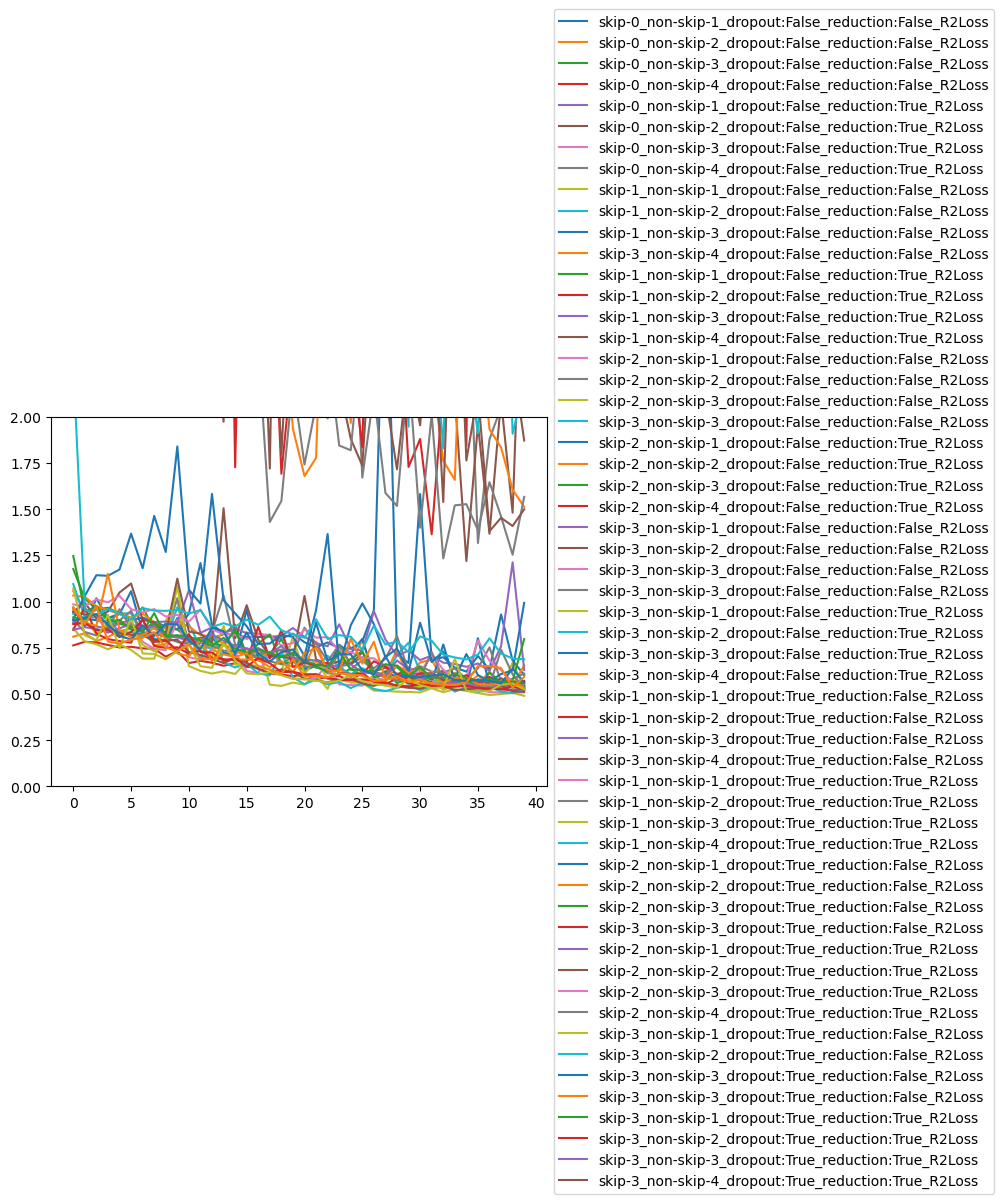

In [54]:
past_record = pd.read_csv("mse.csv",index_col=0)
def plot_loss(df):
    ax = df.T.plot(kind="line")
    ax.set_ylim(0,2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_loss(past_record)

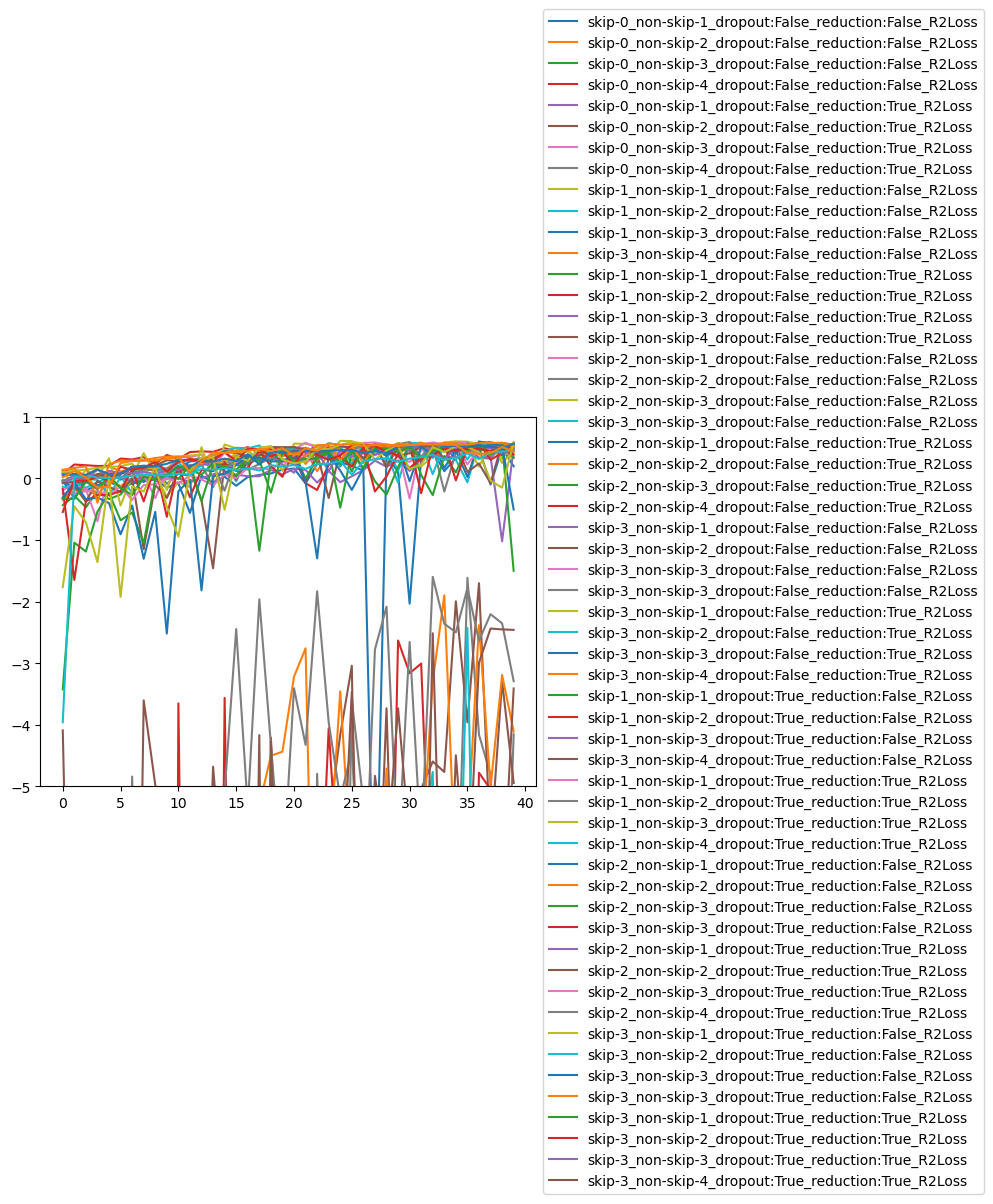

In [63]:
past_record = pd.read_csv("rsquared.csv",index_col=0)
def plot_loss(df):
    ax = df.T.plot(kind="line")
    ax.set_ylim(-5,1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def change(x):
    if type(x) == str:
        return float(x.replace("tensor(", "").replace(")", ""))
    return x

plot_loss(past_record.applymap(change))

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
#time to attempt to reverse engineer the datasets!

In [ ]:

def pred_zscore_to_real_price(model, X, mean, std):
    model.eval()

    def run_model_in_df(x):
        with torch.no_grad():
            row = torch.Tensor(np.array(x.values, dtype=float))
            preds = model(row)
            preds = np.array(preds)
            preds = preds * std + mean
        return preds

    preds = X.apply(run_model_in_df, axis=1)

    return preds

preds = pred_zscore_to_real_price(model, X_test, mean, std)

mean_squared_error(y_test, preds)

In [ ]:
r2_score(y_test, preds)

In [ ]:
final_train_dataset = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])
train_dev_loader = DataLoader(dataset=final_train_dataset, batch_size=32, shuffle=True)
model = NNRegressor_V1()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
correctness =[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, test_loss = train_loop(train_dev_loader, valid_dataloader, model, loss_fn, optimizer)
    losses.extend(loss)
    correctness.append(test_loss)
print("Done!") 

preds = pred_zscore_to_real_price(model, X_test, mean, std)

mean_squared_error(y_test, preds), r2_score(y_test, preds)